# Jaké rysy dělají ze skladby hit?

## Analýza charakteristických atributů hudebních skladeb ze Spotify

Předmětem analýzy jsou charakteristické atributy skladeb ze Spotify, jako je jejich tempo, tónina, energičnost, délka apod. (celkem 19 atributů). Cílová proměnná je údaj, zda se skladba v daném období stala populárním mainstreamovým hitem či nikoli (hit/flop) a tuto vlastnost se také budeme snažit predikovat. Jde o ověření domněnky, že všeobecně přijímané populární skladby mají jisté společné měřitelné vlastnosti a jejich líbivost lze algoritmicky dokázat, případně i predikovat a strojově vytvářet.

# Popis dat a jejich struktury 

Pro analýzu je k dispozici široká a volně stažitelná databáze záznamů o všech skladbách dostupných na Spotify přes Spotify API. Pro tuto semestrální práci využijeme již předzpracovaný dataset z Kaggle https://www.kaggle.com/theoverman/the-spotify-hit-predictor-dataset, kde autor spojil data pomocí "spotipy": Python module for Spotify's API (https://pypi.org/project/spotipy/) a "billboard": Python module for Billboard's API (https://pypi.org/project/billboard.py/). U dat neočekáváme špatně zadané hodnoty.

# Příprava dat

Import a nastavení esenciálních knihoven

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize']=(20,5)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Import, agregace a explorace dat

Z dostupného datasetu jsme vybrali pro nás relevantnější podmnožinu dat z období 1990-2019. Přidali jsme odvozený atribut "era" podle desetiletí, abychom tuto informaci neztratili a datasety spojili do společného dataframu, který si prohlédneme.

In [2]:
start = time.time()

nineties = pd.DataFrame(pd.read_csv('data/dataset-of-90s.csv')) #Spotify dataset skladeb z devadesátek
aughts = pd.DataFrame(pd.read_csv('data/dataset-of-00s.csv'))  #Spotify dataset skladeb začátku tisíciletí
tens = pd.DataFrame(pd.read_csv('data/dataset-of-10s.csv'))  #Spotify dataset skladeb po roce 2010

nineties["era"]=1990
aughts["era"]=2000
tens["era"]=2010
all_dfs = [nineties, aughts, tens]
all_tracks = pd.concat(all_dfs)
all_tracks.head(5)
all_tracks.columns
pd.isnull(all_tracks).sum()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,era
0,Misty Roses,Astrud Gilberto,spotify:track:50RBM1j1Dw7WYmsGsWg9Tm,0.527,0.316,1,-15.769,1,0.0310,0.693000,0.00699,0.1680,0.543,116.211,158840,4,53.89523,6,0,1990
1,Never Ever,All Saints,spotify:track:5FTz9qQ94PyUHETyAyfYZN,0.738,0.541,1,-5.485,1,0.0311,0.559000,0.00000,0.0492,0.309,134.187,387573,4,32.16853,16,1,1990
2,Soul Sermon,Gregg Karukas,spotify:track:6m24oe3lk1UMxq9zq4iPFi,0.736,0.419,0,-10.662,1,0.0300,0.693000,0.49500,0.0809,0.265,93.982,237267,4,42.05369,9,0,1990
3,Clarinet Marmalade - Live,Alton Purnell,spotify:track:5FOXuiLI6knVtgMUjWKj6x,0.565,0.594,5,-13.086,1,0.0646,0.655000,0.92600,0.6750,0.763,114.219,375933,4,80.99693,10,0,1990
4,До смерті і довше - Drum & Base and Rock Remix,Skryabin,spotify:track:6CxyIPTqSPvAPXfrIZczs4,0.513,0.760,4,-10.077,1,0.0355,0.000017,0.00339,0.1530,0.961,153.166,430653,4,25.57331,20,0,1990


Index(['track', 'artist', 'uri', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
       'sections', 'target', 'era'],
      dtype='object')

track               0
artist              0
uri                 0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
chorus_hit          0
sections            0
target              0
era                 0
dtype: int64

## Popis dat

| Název             | Datový typ       | Rozmezí     | Popis                                                                                                                                                                   |
|-------------------|------------------|-------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| track             | text             | N/A         | Název                                                                                                                                                                   |
| artist            | text             | N/A         | Autor                                                                                                                                                                   |
| uri               | text             | N/A         | ID                                                                                                                                                                      |
| danceability      | Desetinné číslo  | 0.0 až 1.0  | Faktor, jak moc je skladba vhodná k tanci (především rytmičnost a stálost rytmu)                                                                                        |
| energy            | Desetinné číslo  | 0.0 až 1.0  | Energie / intenzita skladby                                                                                                                                             |
| key               | Celé číslo       | 0 až 11     | Tónina, která ve skladbě převažuje (-1 pokud nelze určit)                                                                                                               |
| loudness          | Celé číslo       | -60 až 0    | Celková hlasitost v dB                                                                                                                                                  |
| mode              | Celé číslo       | 0 nebo 1    | Durová či molová tónina                                                                                                                                                 |
| speechiness       | Desetinné číslo  | 0.0 až 1.0  | Zda je obsaženo mluvené slovo – do 0.33 téměř vůbec, mezi 0.33 a 0.66 se střídavě vyskytuje a více než 0.66 je převážně mluvené slovo (podcasty, poezie, audio knihy)   |
| acousticness      | Desetinné číslo  | 0.0 až 1.0  | Odhad, zda je skladba nahrána akusticky či nikoliv                                                                                                                      |
| instrumentalness  | Desetinné číslo  | 0.0 až 1.0  | Zda a nakolik je skladba instrumentální, či obsahuje vokály                                                                                                             |
| liveness          | Desetinné číslo  | 0.0 až 1.0  | Zda byla skladba nahrána naživo či ve studiu (hodnoty nad 0.8 značí vysokou pravděpodobnost, že byla skladba nahrána živě)                                              |
| valence           | Desetinné číslo  | 0.0 až 1.0  | Zda skladba zní více pozitivně (šťastně, optimisticky) či negativně (smutně, naštvaně)                                                                                  |
| tempo             | Desetinné číslo  | 0 až 300    | Tempo (odhad) BPM (počet dob/úderů za minutu)                                                                                                                           |
| duration_ms       | Celé číslo       | N/A         | Doba trvání skladby v ms                                                                                                                                                |
| time_signature    | Celé číslo       | 0 až 10     | Takt – počet dob v taktu (odhad)                                                                                                                                        |
| chorus_hit        | Desetinné číslo  | N/A         | Odhad doby začátku refrénu                                                                                                                                              |
| sections          | Celé číslo       | 0 až 100    | Počet rozlišitelných částí skladby                                                                                                                                      |
| target            | Celé číslo       | 0 nebo 1    | Informace, zda byla v daném období skladba hitem či ne   

## Úprava dat

Z prvního pohledu na agregovaná data je patrné, že pro další zpracování můžeme smazat sloupec "uri", který je identifikátorem skladeb. Dále můžeme odvodit sloupec trvání skladby ve vteřinách místo milisekund, v Pandas se to pak neformátuje ve vědecké notaci - tj. je to jednodušší přečíst. Původní sloupec s milisekundami můžeme také smazat.  Sloupec "target" přejmenujeme na "hit" pro větší srozumitelnost. Vidíme, že žádné hodnoty nechybí, takže tuto vlastnost nemusíme ošetřovat.

In [3]:
all_tracks.rename(columns={"target": "hit"},inplace=True)
all_tracks["duration_s"] = all_tracks["duration_ms"] / 1000
drop_cols = ["uri", "duration_ms"]
all_tracks = all_tracks.drop(drop_cols, axis = 1)
all_tracks.head(5)

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,chorus_hit,sections,hit,era,duration_s
0,Misty Roses,Astrud Gilberto,0.527,0.316,1,-15.769,1,0.0310,0.693000,0.00699,0.1680,0.543,116.211,4,53.89523,6,0,1990,158.840
1,Never Ever,All Saints,0.738,0.541,1,-5.485,1,0.0311,0.559000,0.00000,0.0492,0.309,134.187,4,32.16853,16,1,1990,387.573
2,Soul Sermon,Gregg Karukas,0.736,0.419,0,-10.662,1,0.0300,0.693000,0.49500,0.0809,0.265,93.982,4,42.05369,9,0,1990,237.267
3,Clarinet Marmalade - Live,Alton Purnell,0.565,0.594,5,-13.086,1,0.0646,0.655000,0.92600,0.6750,0.763,114.219,4,80.99693,10,0,1990,375.933
4,До смерті і довше - Drum & Base and Rock Remix,Skryabin,0.513,0.760,4,-10.077,1,0.0355,0.000017,0.00339,0.1530,0.961,153.166,4,25.57331,20,0,1990,430.653


# Deskriptivní analýza

## Histogramy

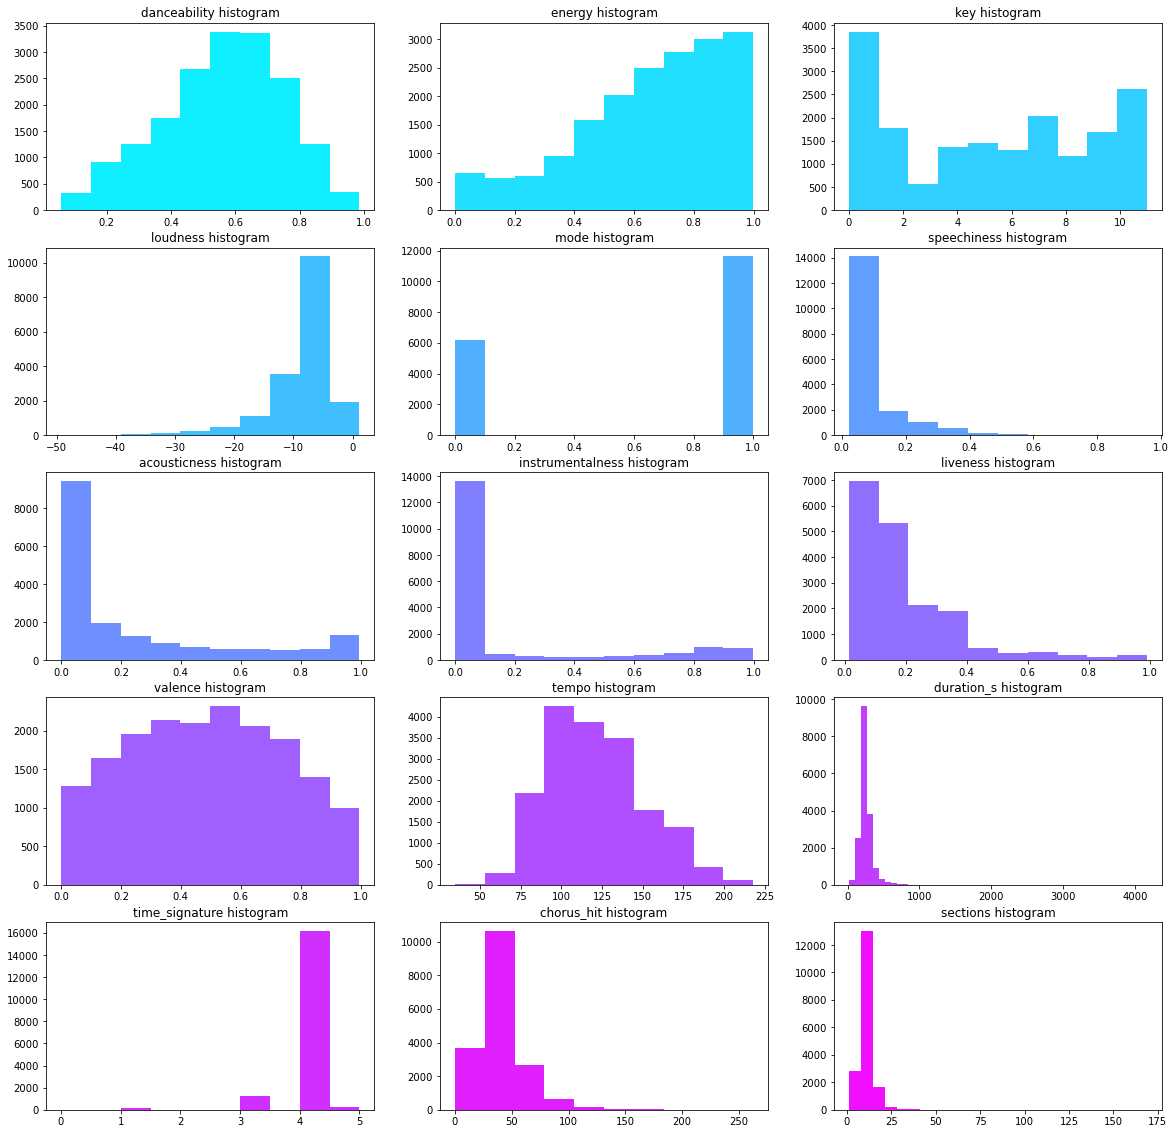

In [4]:
fig, ax = plt.subplots(5,3, figsize=(20,20))

palette = sns.color_palette("cool", 15)
palette_hex = palette.as_hex()

def hist_plot(row, column, variable, binsnum):
    ax[row, column].hist(all_tracks[variable], bins = binsnum, color = palette_hex[row*3+column])
    ax[row, column].set_title(variable + ' histogram')

    
hist_plot(0, 0, 'danceability', 10)
hist_plot(0, 1, 'energy', 10)
hist_plot(0, 2, 'key', 10)
hist_plot(1,0, 'loudness', 10)
hist_plot(1,1, 'mode', 10)
hist_plot(1,2, 'speechiness', 10)
hist_plot(2,0, 'acousticness', 10)
hist_plot(2,1, 'instrumentalness', 10)
hist_plot(2,2, 'liveness', 10)
hist_plot(3,0, 'valence', 10)
hist_plot(3,1, 'tempo', 10)
hist_plot(3,2, 'duration_s', 50)
hist_plot(4,0, 'time_signature', 10)
hist_plot(4,1, 'chorus_hit', 10)
hist_plot(4,2, 'sections', 25)

plt.show()

Z histogramů vidímě, že některé hodnoty nejspíš nebudu příliš vhodné pro analýzu, jako je time_signature, kde dominuje hodnota 4 u všech vzorků, nebo duration a sections, které jsou zřejmě korelované.

Pro základní přehled o datech použijeme metodu describe a vytvoříme si korelační matici.

In [5]:
all_tracks.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,chorus_hit,sections,hit,era,duration_s
count,17790.000000,17790.000000,17790.000000,17790.000000,17790.000000,17790.000000,17790.000000,17790.000000,17790.000000,17790.000000,17790.00000,17790.000000,17790.000000,17790.000000,17790.000000,17790.000000,17790.000000
mean,0.559440,0.656260,5.274817,-8.364215,0.652839,0.088697,0.239137,0.158870,0.196671,0.485603,121.01916,3.922709,40.922312,10.812760,0.500000,2000.493536,249.842392
std,0.187818,0.246307,3.562926,5.305503,0.476081,0.092549,0.307601,0.308722,0.167451,0.255318,29.88302,0.379259,19.909212,4.738156,0.500014,8.170243,111.714318
min,0.057600,0.000251,0.000000,-49.253000,0.000000,0.022000,0.000000,0.000000,0.013000,0.000000,34.53500,0.000000,0.000000,1.000000,0.000000,1990.000000,15.920000
25%,0.437000,0.505000,2.000000,-9.911000,0.000000,0.035700,0.008810,0.000000,0.093600,0.278000,97.16900,4.000000,27.884680,8.000000,0.000000,1990.000000,200.046750
50%,0.577000,0.700000,5.000000,-6.902000,1.000000,0.050400,0.081600,0.000046,0.128000,0.487000,119.87800,4.000000,36.258675,10.000000,0.500000,2000.000000,233.457000
75%,0.697000,0.857000,8.000000,-5.028000,1.000000,0.096700,0.377000,0.061500,0.257000,0.690000,140.00075,4.000000,48.306250,12.000000,1.000000,2010.000000,276.683000
max,0.986000,0.999000,11.000000,1.137000,1.000000,0.956000,0.996000,0.998000,0.992000,0.996000,217.94300,5.000000,262.615400,169.000000,1.000000,2010.000000,4170.227000


<Figure size 1080x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Correlation Matrix')

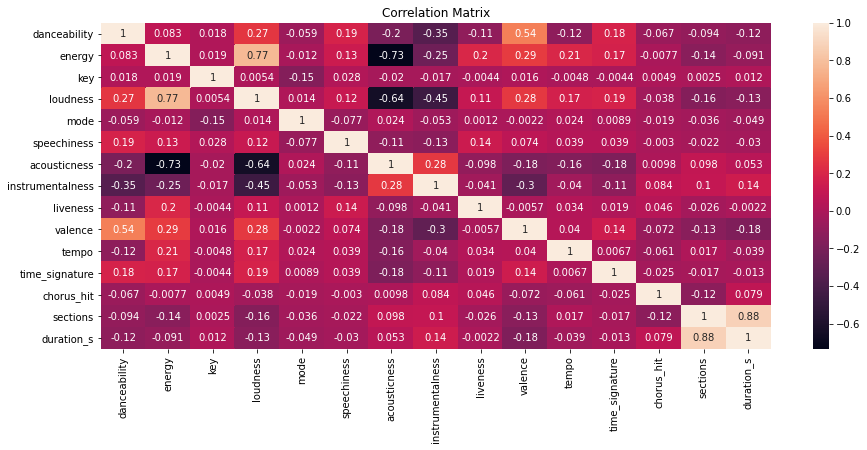

In [6]:
features = ['track', 'artist', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                'valence', 'tempo', 'time_signature', 'chorus_hit','sections', 'duration_s']
X = all_tracks[features]

plt.figure(figsize=(15,6))
sns.heatmap(X.corr(),annot=True)
plt.title("Correlation Matrix")
plt.show()

Vidíme, že atributy energy a loudness nebo sections a duration spolu významně pozitivně korelují, naopak energy a acousticness spolu významně korelují negativně. Tuto znalost využijeme v prediktivních modelech, ale prozatím nebudeme žádné atributy mazat.

Dále porovnáme průměrné hodnoty atributů obou podmnožin našeho datasetu rozdělených podle cílového atributu "hit". Vybrané atributy nezahrnují atribut "era", který je z podstaty v našich datech rozložen rovnoměrně. 

In [7]:
all_tracks_hits = all_tracks[features].loc[all_tracks['hit'] == 1]
all_tracks_flops = all_tracks[features].loc[all_tracks['hit'] == 0]

hits_means = pd.DataFrame(all_tracks_hits.describe().loc['mean'])
flops_means = pd.DataFrame(all_tracks_flops.describe().loc['mean'])
means_joined = pd.concat([hits_means,flops_means], axis = 1)
means_joined.columns = ['hit_mean', 'flop_mean']

means_joined

,hit_mean,flop_mean
danceability,0.640024,0.478857
energy,0.685306,0.627215
key,5.335020,5.214615
loudness,-6.631530,-10.096899
mode,0.670826,0.634851
speechiness,0.095196,0.082198
acousticness,0.159774,0.318499
instrumentalness,0.014353,0.303387
liveness,0.183355,0.209987
valence,0.540854,0.430352


In [8]:
hits_means = pd.DataFrame(all_tracks_hits.describe().loc['mean'])
flops_means = pd.DataFrame(all_tracks_flops.describe().loc['mean'])
means_joined = pd.concat([hits_means,flops_means], axis = 1)
means_joined.columns = ['hit_mean', 'flop_mean']

means_joined

,hit_mean,flop_mean
danceability,0.640024,0.478857
energy,0.685306,0.627215
key,5.335020,5.214615
loudness,-6.631530,-10.096899
mode,0.670826,0.634851
speechiness,0.095196,0.082198
acousticness,0.159774,0.318499
instrumentalness,0.014353,0.303387
liveness,0.183355,0.209987
valence,0.540854,0.430352


Vidíme, že některé hodnoty jsou si velmi podobné, ale některé se liší více, např. danceability, loudness, acousticness. Tyto atributy zřejmě budou ovlivňovat náš cílový atribut a má smysl pokračovat v analýze.

# Prediktivní modely

Jako první metodu prediktivní analýzy použijeme lineární regresi, jako druhou jsme vybrali random forrest klasifikátor. Data rozdělíme metodou train_test_split v poměru 75% trénovací data a 25% testovací - tento poměr se ukázal jako nejlepší.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale

features = ['danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_s', 'time_signature', 'chorus_hit',
       'sections']

X = all_tracks[features]
y = all_tracks['hit']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0) 

## Logistická regrese

V korelačnej matici síce niektoré prvky významne korelujú, ale pretestovali sme všetky možnosti a dospeli k záveru, že model logistickej regresie má najvyššiu presnosť ak ich do modelovania zahrnieme. Metoda ktoru sme vybrali zahrňuje crossvalidáciu a GridSearch. Kombinácia parametrov cv=3 a CS=5 (3-fold) sa ukázalo ako najvhodnejšia, hlavne kvôli rýchlosti výpočtu a samozrejme presnosti modelu.

In [10]:
from sklearn.linear_model import LogisticRegressionCV
model_LR_cv = LogisticRegressionCV(cv=3,Cs=5,scoring = "accuracy" )

model_LR_cv.fit(X_train, y_train)

LogisticRegressionCV(Cs=5, cv=3, scoring='accuracy')

[Text(0.5, 1.0, 'Confusion matrix for Logistic Regression')]

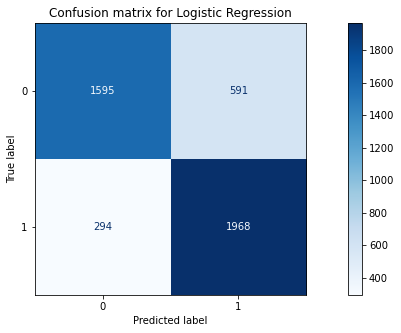

In [11]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(15,5))
plot_confusion_matrix(model_LR_cv, X_test, y_test, cmap=plt.cm.Blues, ax = ax)
ax.set(title='Confusion matrix for Logistic Regression')

In [12]:
def confusion_matrix_values(cm):
    print('True positive = ', cm[1][1])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[0][0])

y_pred_LR_cv = model_LR_cv.predict(X_test)

from sklearn import metrics
cm_cv = metrics.confusion_matrix(y_test, y_pred_LR_cv)
cm_cv
confusion_matrix_values(cm_cv)

# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_LR_cv)

array([[1595,  591],
       [ 294, 1968]])

True positive =  1968
False positive =  591
False negative =  294
True negative =  1595


0.8010341726618705

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=3)

# Fit it to the data
logreg_cv.fit(X_train, y_train)

# Print the tuned parameter and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08])})

Tuned Logistic Regression Parameters: {'C': 2275.845926074791}
Best score is 0.7860140266469081


Pre zaujímavosť sme vyskúšali regularizáciu manuálne pričom sme ale dostali nižšiu presnosť modelu, takže do úvahy budeme brať prvý model Logistickej regresie.

## Random Forrest Klasifikátor

In [14]:
model_RF = RandomForestClassifier()
model_RF.fit(X_train, y_train)
y_pred_RF = model_RF.predict(X_test)

RandomForestClassifier()

In [15]:
cm_rfc = metrics.confusion_matrix(y_test, y_pred_RF)
cm_rfc
confusion_matrix_values(cm_rfc)

accuracy_score(y_test, y_pred_RF)

array([[1774,  412],
       [ 295, 1967]])

True positive =  1967
False positive =  412
False negative =  295
True negative =  1774


0.8410521582733813

<AxesSubplot:>

Text(0.5, 1.1, 'Confusion matrix for Random Forrest Classifier')

Text(33.0, 0.5, 'Actual label')

Text(0.5, 320.8, 'Predicted label')

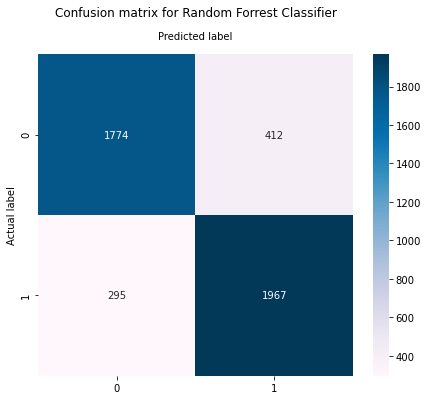

In [16]:
mpl.rcParams['figure.figsize']=(6,5)
fig, ax = plt.subplots()

# seaborn heatmap
sns.heatmap(pd.DataFrame(cm_rfc), annot=True, cmap="PuBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix for Random Forrest Classifier', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label', labelpad=15)
plt.show()

Získali jsme lepší výsledek než při použití LR, ale zkusíme model ještě vylepšit. V RFC zjistíme a seřadíme atributy, podle toho, jak přispívají v modelu, tj. které features jsou v rozhodování nejdůležitější.

In [17]:
all_songs_feat = model_RF.feature_importances_
df_indep_columns = pd.DataFrame(features)
df_all_songs_feat = pd.DataFrame(all_songs_feat)
all_songs_feat_vars = pd.concat([df_indep_columns, df_all_songs_feat], axis = 1)
all_songs_feat_vars.columns = ['Variable', 'Feature importance']
all_songs_feat_vars = all_songs_feat_vars.set_index('Variable')
all_songs_feat_vars = all_songs_feat_vars.sort_values(by=['Feature importance'], ascending = False)
all_songs_feat_vars

,Feature importance
Variable,
instrumentalness,0.201019
danceability,0.132018
acousticness,0.102602
loudness,0.084946
duration_s,0.083426
energy,0.081648
valence,0.065541
speechiness,0.053301
tempo,0.044488


Odebereme méně důležité atributy a porovnáme výsledky analýzy.

In [18]:
indep_columns_subset = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'duration_s', 'loudness']

X = all_tracks[indep_columns_subset]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0) # RFC vybírá data náhodně i přes definovaný seed, 
# proto se výsledky lehce lisí při každém spuštění

model_RF.fit(X_train, y_train)

y_pred_RF_2 = model_RF.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred_RF_2)
cnf_matrix

accuracy_score(y_test, y_pred_RF_2)

RandomForestClassifier()

array([[1743,  443],
       [ 312, 1950]])

0.8302607913669064

Dostali jsme lehce horší výsledky než při použití všech atributů. Vynechání korelovaných atributů taktéž zlepšení nepřineslo.

In [19]:
# reset hodnot zpět na všech 15 sloupců a fit na původní (lepší) RFC model
X = all_tracks[features]
y = all_tracks['hit']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0) 

model_RF.fit(X_train, y_train)

RandomForestClassifier()

## Support Vector Machine


In [20]:
from sklearn import svm

# indep_columns_subset = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'duration_s', 'loudness']
# X = all_tracks[indep_columns_subset]
# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0) 

#model_SVM = svm.SVC()
#model_SVM.fit(X_train, y_train)
#y_pred_SVM = model_SVM.predict(X_test)

#cnf_matrix = metrics.confusion_matrix(y_test, y_pred_SVM)
#cnf_matrix

#accuracy_score(y_test, y_pred_SVM)

Vyzkoušeli jsme také metodu SVM, která se ale ukázala jako nevhodná, proto jsme ji ani nezahrnuli do porovnání - dává výrazně horší výsledky než předchozí dvě metody za cenu mnohonásobně delšího trénování modelu a to jak s původním setem 15 atributů, tak s výberem 6 nejvýznamnějších. Pro porovnání stačí odkomentovat - exekuce trvá asi půl minuty navíc.

## ROC Křivky
### Logisticská Regrese

<Figure size 432x360 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Logistic Regression ROC curve')

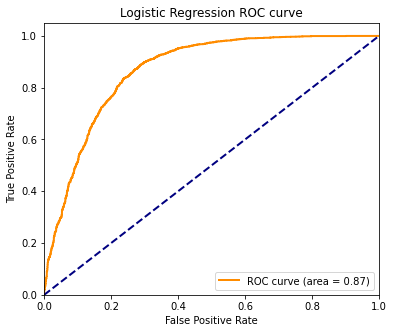

In [21]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_test_probs = model_LR_cv.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
roc_auc = roc_auc_score(y_test, y_test_probs)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC curve')
plt.legend(loc="lower right")
plt.show()

Random Forest Classifier

<Figure size 432x360 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Random forest ROC curve')

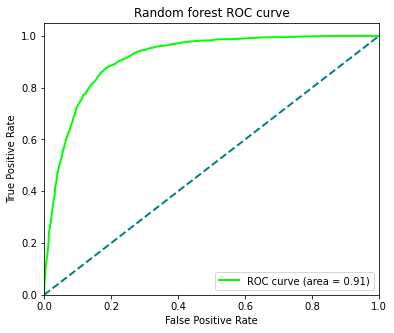

In [22]:
#ROC curve - Random forest
y_test_probs = model_RF.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
roc_auc = roc_auc_score(y_test, y_test_probs)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='lime',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='teal', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random forest ROC curve')
plt.legend(loc="lower right")
plt.show()

# Evaluace
Porovnáme výsledky obou metod názorně pomocí matic záměn a v grafu ROC křivek obou modelů.

[Text(0.5, 1.0, 'LinR')]

[Text(0.5, 1.0, 'RandF')]

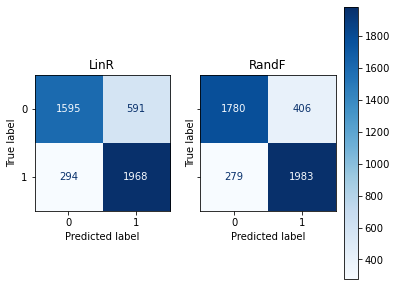

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, gridspec_kw={'width_ratios':[4,5]}) # při vynechání colorbaru se první graf zvětší, proto je potřeba přenastavit poměr
plot_confusion_matrix(model_LR_cv, X_test, y_test, cmap=plt.cm.Blues, ax = ax1, colorbar=False)
plot_confusion_matrix(model_RF, X_test, y_test, cmap=plt.cm.Blues, ax = ax2)
ax1.set(title='LinR')
ax2.set(title='RandF')
plt.show()

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC comparison LR x RFC')

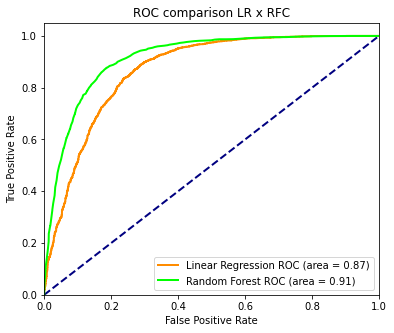

In [24]:
y_test_probs = model_LR_cv.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
roc_auc = roc_auc_score(y_test, y_test_probs)
plt.figure(0).clf()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Linear Regression ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC comparison LR x RFC')

#ROC curve - Random forest
y_test_probs = model_RF.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
roc_auc = roc_auc_score(y_test, y_test_probs)
plt.plot(fpr, tpr, color='lime',
         lw=lw, label='Random Forest ROC (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.show()

end = time.time()

In [25]:
print( "Exekuce celého notebooku trvala %3.2f s" % (end - start))

Exekuce celého notebooku trvala 42.29 s


# Záver

Pre modelovanie sme si vybrali 2 modely - Random Forest a Logistickú regresiu so vstavanou crossvalidáciou a vstavaným GridSearch. Random forest dosahiol vyššiu presnosť (84.1% vs 80.1%). Čo sa týka ROC krivky tak Random Forest dosiahol tiež vyššiu hodnotu (90 vs 86 AUC). Oba modely v naší konfiguraci a datové sadě trvaly přibližně stejně dlouho natrénovat, proto jako nejlepší prediktivní model v našem případě vyšel Random Forest Klasifikátor.